In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from datasets import load_dataset
import os

In [11]:
num_clusters = 6

# Extract Lab Values

In [1]:
def extract_lab_features(image):
    image = np.array(image)
    # Identify black pixels in the original image (RGB values are all zero)
    black_mask = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) == 0
    # Create an inverse mask for non-black pixels
    non_black_mask = ~black_mask

    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    L_channel, A_channel, B_channel = cv2.split(lab_image)

    # Apply the non-black mask to each channel
    L_non_black = L_channel[non_black_mask]
    A_non_black = A_channel[non_black_mask]
    B_non_black = B_channel[non_black_mask]

    if L_non_black.size == 0:
        l_mean = 0
        a_mean = 0
        b_mean = 0
    else:
        l_mean = np.mean(L_non_black)
        a_mean = np.mean(A_non_black)
        b_mean = np.mean(B_non_black)

    return l_mean, a_mean, b_mean

In [2]:
images = []
l_values = []
a_values = []
b_values = []

In [5]:
dataset = load_dataset("e1010101/tongue-images-all-cropped")

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'pixel_values'],
        num_rows: 1054
    })
})

In [7]:
for image_file in tqdm(dataset['train']['image'], desc="Parsing images"):
    l_mean, a_mean, b_mean = extract_lab_features(image_file)
    
    images.append(image_file)
    l_values.append(l_mean)
    a_values.append(a_mean)
    b_values.append(b_mean)

Parsing images: 100%|██████████| 1054/1054 [00:00<00:00, 3082.12it/s]


In [8]:
df = pd.DataFrame({
    'image': images,
    'L': l_values,
    'A': a_values,
    'B': b_values
})

In [9]:
overall_L_mean = df['L'].mean()

# K-Means Clustering

In [12]:
X = df[['A', 'B']]
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
df

c:\Users\ezrat\anaconda3\envs\Standard\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,image,L,A,B,cluster
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,85.402344,157.322510,149.731445,1
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,153.670410,140.332764,130.886719,0
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,195.586426,134.861816,122.540039,2
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,192.550537,149.169434,139.761230,1
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,132.603516,140.534668,121.354004,2
...,...,...,...,...,...
1049,<PIL.PngImagePlugin.PngImageFile image mode=RG...,153.898682,144.550049,120.465332,0
1050,<PIL.PngImagePlugin.PngImageFile image mode=RG...,193.427246,154.416748,161.262451,5
1051,<PIL.PngImagePlugin.PngImageFile image mode=RG...,87.361328,144.697754,140.202637,4
1052,<PIL.PngImagePlugin.PngImageFile image mode=RG...,134.747314,138.777344,125.085693,2


# Visualizations

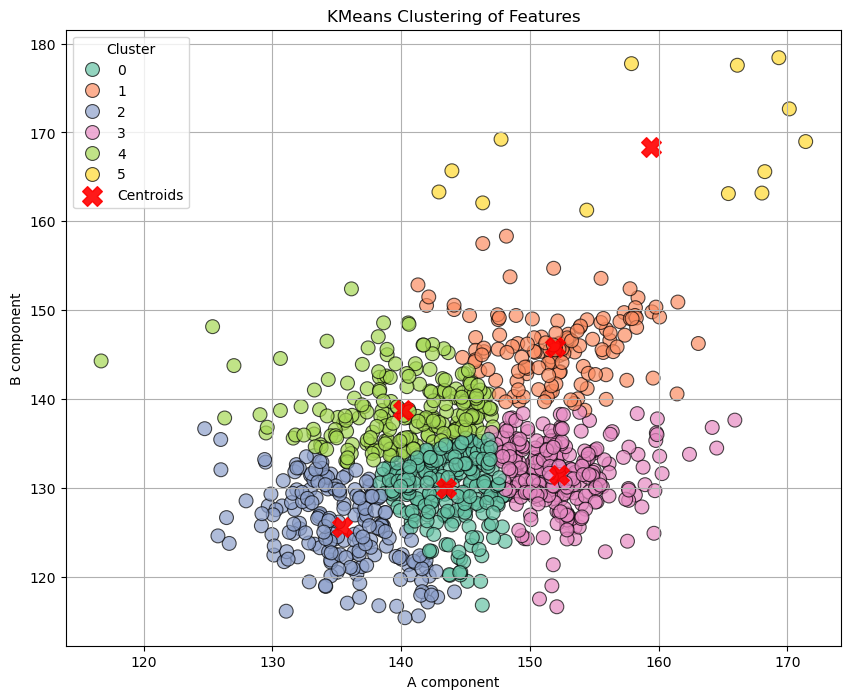

In [13]:
centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='A',
    y='B',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='k',
    alpha=0.7
)

# Plot the cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='red',
    s=200,
    alpha=0.9,
    marker='X',
    label='Centroids'
)

# Customize the plot
plt.title('KMeans Clustering of Features')
plt.xlabel('A component')
plt.ylabel('B component')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.show()

# Statistics

In [18]:
cluster_means = df.groupby('cluster')[['A', 'B']].mean().reset_index()
cluster_max = df.groupby('cluster')[['A', 'B']].max().reset_index()
cluster_min = df.groupby('cluster')[['A', 'B']].min().reset_index()

In [19]:
cluster_means.columns = ['cluster', 'A_mean', 'B_mean']
cluster_max.columns = ['cluster', 'A_max', 'B_max']
cluster_min.columns = ['cluster', 'A_min', 'B_min']

In [20]:
combined_cluster_df = pd.merge(cluster_means, cluster_max, on='cluster')
combined_cluster_df = pd.merge(combined_cluster_df, cluster_min, on='cluster')

In [21]:
combined_cluster_df

,cluster,A_mean,B_mean,A_max,B_max,A_min,B_min
0,0,137.081330,104.801318,144.367920,109.821045,124.267090,98.943848
1,1,147.907422,84.684021,155.666748,92.317139,136.412598,63.738770
2,2,135.956344,113.224668,145.760986,121.160889,125.305664,108.207764
3,3,131.693958,122.463988,141.979736,133.323242,113.227539,115.192627
4,4,139.195340,93.793691,144.823975,98.820557,126.930908,86.383545
5,5,144.781571,99.242314,153.154053,108.723145,139.439453,93.057129


In [22]:
def lab_to_rgb(l, a, b):
    # Create a 1x1 LAB image
    lab_color = np.uint8([[[l, a, b]]])
    # Convert LAB to BGR
    bgr_color = cv2.cvtColor(lab_color, cv2.COLOR_LAB2BGR)
    # Convert BGR to RGB
    rgb_color = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2RGB)
    # Flatten the array
    rgb_color = rgb_color.flatten()
    return rgb_color

In [25]:
cluster_means_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_mean'], x['B_mean'], overall_L_mean), axis=1)
cluster_max_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_max'], x['B_max'], overall_L_mean), axis=1)
cluster_min_rgb = combined_cluster_df.apply(lambda x: lab_to_rgb(x['A_min'], x['B_min'], overall_L_mean), axis=1)

combined_cluster_df['RGB_mean'] = cluster_means_rgb
combined_cluster_df['RGB_max'] = cluster_max_rgb
combined_cluster_df['RGB_min'] = cluster_min_rgb

In [20]:
cluster_colors = []

for _, row in cluster_means.iterrows():
    l_mean = overall_L_mean
    a_mean = row['A_mean']
    b_mean = row['B_mean']
    rgb_color = lab_to_rgb(l_mean, a_mean, b_mean)
    cluster_colors.append(rgb_color)

# Image Saving

In [21]:
def save_clustered_images(df, base_output_dir):
    os.makedirs(base_output_dir, exist_ok=True)
    
    for cluster in df['cluster'].unique():
        cluster_dir = os.path.join(base_output_dir, f'cluster_{cluster}')
        os.makedirs(cluster_dir, exist_ok=True)
        cluster_images = df[df['cluster'] == cluster]
        
        for idx, row in cluster_images.iterrows():
            image = row['image']
            image_path = os.path.join(cluster_dir, f'image_{idx}.jpg')
            image.save(image_path)

    print("Image saving complete")

In [22]:
output_directory = "clusters/clustered_images"
save_clustered_images(df, output_directory)

Base output directory: clusters/coating_center/6-clusters


Copying images: 100%|██████████| 894/894 [00:00<00:00, 1076.76it/s]
